# Image Deblurring - June Exam

## Giorgio Buzzanca - 0000983746

### Introduction

Cifar-10 images have been blurred by applying a 5x5 Gaussian kernel with the same random standard deviation in X and Y directions, and perturbated with additive gaussian white noise.

Ideally, we could split the task into two different subtasks, which are namely denoising and deblurring, and we could use two different models, but in practice, since we cannot modify the dataset creation procedure, we must use a single model. 

In addition, in this particular scenario, most of the images' degradation comes from blurring.

There has been extensive work in the literature on image restoration tasks, having CNNs as the main protagonist, employed both in discriminative and generative models.

Even though generative models have proven to be successful in certain scenarios, currently the state of the art is dominated by discriminative models.

For these reasons, I implemented Restormer, which is the current state of the art (for several datasets) for image defocusing, deblurring, and deraining.

In addition, just for the sake of comparison, I implemented variations of two different well-known models, namely U-Net and REDNet 30.

Since the latter two are relatively simple models, studied during the course, and are indeed employed only to establish a baseline for the task, most of the discussion and the digging into theoretical aspects is devolved to Restormer.

In addition, even though the most important metric adopted for comparison is the mean squared error, I decided to train models using the logarithm of the hyperbolic cosine of the prediction error as loss function and to also take a look at two other extensively used metrics: peak signal to noise ratio, and the structural similarity index (SSIM).

The first choice comes from the fact that log cosh combines the advantage of the absolute error loss function of not overweighting outliers while behaving stable during gradient descent search like the mean squared error ($log(cosh(x))$ is approximately equal to $\frac{x^2}{2}$ for small values of $x$ and to $|x| − log(2)$ for larger values). I found out experimentally that using it can result in better performances with respect to all aforementioned metrics.

The second choice comes simply from the fact that in the case of a tie between two models with respect to mean squared error, I would have needed a different metric to look at. 
While PSNR, which I adopted only because I find it more human-readable, is nothing more than a normalized version of the mean squared error, SSIM is better suited when it comes to evaluating performances of image restoration from a perceptual point of view, as it aims to estimate structural changes (as shifts in luminance or contrast).

I used Cosine Annhealing (https://arxiv.org/abs/1608.03983v5) as learning rate schedule for training all models, with different initial learning rates values specifically tuned for each of them. The reason of this choice is that warm restart has been proved successfull in improving the rate of convergence, and it has also been used in the original Restormer training process.
I trained U-Net and REDNet30 with the Adam optimizer, and the Restormer model with a modified version of it which makes use of weight decaying.

The batch size has been set to 32, and the number of epochs to 20.
Nonetheless, I used EarlyStopping with best weigths restoration and a patience of 3 epochs, and ModelCheckpoint callbacks, and I inspected the training and validation metrics through epochs to find signs of overfitting. Thanks to the callbacks I was able to save the best weights before overfitting occurred.

The notebook follows this structure: all imports needed are placed at the beginning of the notebook, as well as the dataset generation procedure, then each model is introduced, trained, and tested.
As an aid in reading, I added schematic pictures of the models (with references to the papers where I took them from) where it was possible, I printed the summary of each model, and plotted them as graphs making use of the utility provided by Tensorflow.

Finally, I grouped models' metrics in a table, and visually inspected a small sample of restored images taken from the test set.

At the end of the notebook I provide a link to a folder in my Google Drive containing all the weights saved by model checkpoint callbacks.

P.S. I had to come back to the notebook for refactoring reasons (like moving imports at the beginning of the notebook) several times, therefore, should there be a mismatch in the order of execution of the cells, that's the reason. In any case, as asked I kept the output of the training procedure intact.

In [ ]:
# We need these two modules for the Restormer.

# einops is needed to perform tensors' rearrangement operations when applying multi-head attention

# tensorflow-addons is needed to use a modified version of the Adam optimizer, which makes use of weight decay.
# While this is not strictly necessary I wanted to stick as much as possible to the original paper, at least in the early stages of hyperparameters tuning.

!pip install einops
!pip install tensorflow-addons        

import random
import typing

import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, Input, concatenate, MaxPooling2D
import tensorflow_addons as tfa
import einops
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt


# I set the seeds in order to ensure reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.3 MB/s 


### Dataset creation - DO NOT MODIFY

In [ ]:
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [ ]:
(x_train_noise, x_train_original), (x_test_noise, x_test_original) = getDataset()

170508288/170498071 [==============================] - 4s 0us/step


# BASELINE

The most simple baselines are simply the mean squared error, the psnr, and the ssim between the original test set and its blurred version.

In [ ]:
baseline_test_mse = tf.keras.losses.MeanSquaredError()(x_test_original, x_test_noise).numpy()
baseline_ssim = tf.math.reduce_mean(tf.image.ssim(x_test_original.astype("float32"), x_test_noise.astype("float32"), max_val=1.0)).numpy()
baseline_psnr = tf.math.reduce_mean(tf.image.psnr(x_test_original.astype("float32"), x_test_noise.astype("float32"), max_val=1.0)).numpy()

print("Baseline MSE: %.5f" % baseline_test_mse)
print("Baseline SSIM: %.5f" % baseline_ssim)
print("Baseline PSNR: %.5f" % baseline_psnr)

Baseline MSE: 0.00673
Baseline SSIM: 0.65906
Baseline PSNR: 22.36242


# First Model: U-Net

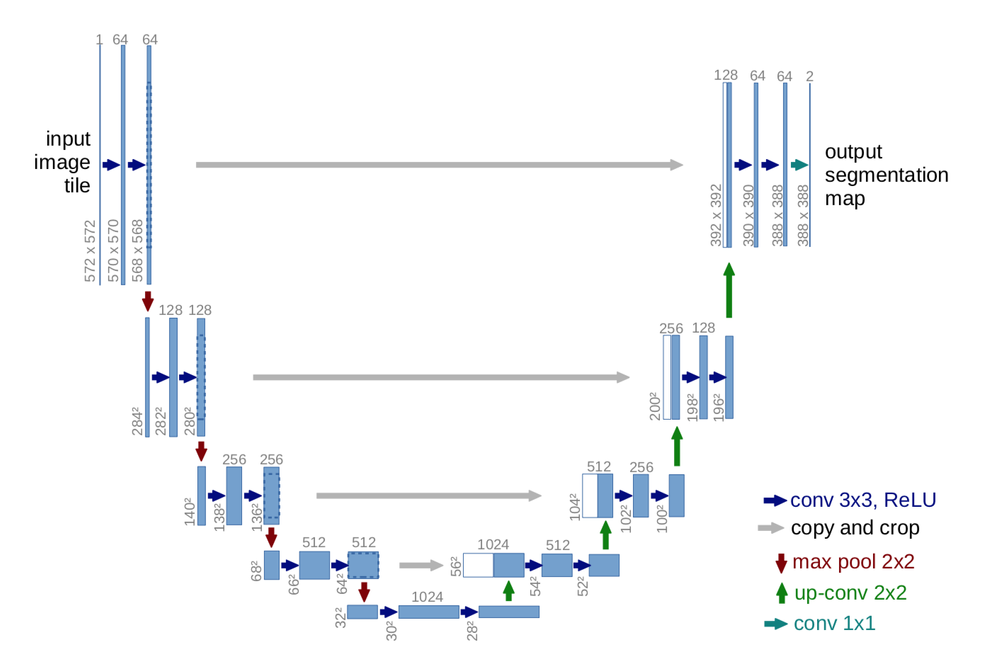

U-Net (https://doi.org/10.48550/arXiv.1505.04597), which has an encoder-decoder like architecture, has been extensively employed for segmentation tasks, but it is suitable also for image denoising.

It has been object of controversy whether one should use max pooling operation or convolutions with a larger stride. On one side the max pooling operation is shift invariant and faster, while on the other side convolution with stride can make the downsampling operation layer-specific, giving more flexibility to the model.

For this reason I tested this architecture both with max pooling operation and with convolutions with a stride of 2.
In addition, I made use of the swish activation function in all layers but the output one (in which I used the relu because it ensures the output is positive), since it has shown promising results in the literature (https://doi.org/10.48550/arXiv.1710.05941).

I also tested it with different number of filters (16, 24, and 32), with the addition of Dropout layers, with the addition of BatchNormalization layers (placed before the activation function), and with a kernel size of 3 or 5.

It unexpectedly turned out that the best performing model was U-Net in its vanilla configuration (with max pooling operations), with 24 filters in the first encoder block, without dropout, and without BatchNormalization.

I did report in this notebook only the training of the best version of U-Net.

In [ ]:
def EncoderBlock(inputs, n_filters=32, kernel_size=3, use_dropout=True, dropout_rate=0.1, reduction=True, max_pooling_reduction=False,
                 batch_normalization=True):
    inputs = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='GlorotNormal', padding='same')(inputs)
    if batch_normalization:
        inputs = BatchNormalization()(inputs)

    inputs = keras.activations.swish(inputs)

    if use_dropout:
        inputs = Dropout(dropout_rate)(inputs)

    if reduction:
        conv = Conv2D(filters=n_filters, kernel_size=kernel_size, strides=(2, 2) if not max_pooling_reduction else (1, 1),
                      kernel_initializer='GlorotNormal', padding='same')(inputs)
    else:
        conv = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='GlorotNormal', padding='same')(inputs)

    if batch_normalization:
        conv = BatchNormalization()(conv)

    conv = keras.activations.swish(conv)

    if use_dropout:
        conv = Dropout(dropout_rate)(conv)

    if reduction and max_pooling_reduction:
        conv = MaxPooling2D(pool_size=(2, 2))(conv)

    return conv, inputs


def DecoderBlock(inputs, skip_connection_inputs, n_filters=32, kernel_size=3, use_dropout=True, dropout_rate=0.1,
                 batch_normalization=True):
    up = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(inputs)
    if batch_normalization:
        up = BatchNormalization()(up)

    merge = concatenate([up, skip_connection_inputs], axis=3)

    conv = Conv2D(n_filters, kernel_size=kernel_size, padding='same', kernel_initializer='GlorotNormal')(merge)
    if batch_normalization:
        conv = BatchNormalization()(conv)

    conv = keras.activations.swish(conv)

    if use_dropout:
        conv = Dropout(dropout_rate)(conv)

    conv = Conv2D(n_filters, kernel_size=kernel_size, padding='same', kernel_initializer='GlorotNormal')(conv)

    if batch_normalization:
        conv = BatchNormalization()(conv)

    conv = keras.activations.swish(conv)
    if use_dropout:
        conv = Dropout(dropout_rate)(conv)

    return conv


def UNetLikeDenoiser(input_size=(32, 32, 3), n_filters=32, kernel_size=3, use_dropout=True, dropout_rate=0.1,
                     max_pooling_reduction=False, batch_normalization=True):
    inputs = Input(input_size)
    
    cblock1 = EncoderBlock(inputs, n_filters, kernel_size, use_dropout, dropout_rate, reduction=True,
                           max_pooling_reduction=max_pooling_reduction, batch_normalization=batch_normalization)
    cblock2 = EncoderBlock(cblock1[0], n_filters*2, kernel_size, use_dropout, dropout_rate, reduction=True,
                           max_pooling_reduction=max_pooling_reduction, batch_normalization=batch_normalization)
    cblock3 = EncoderBlock(cblock2[0], n_filters*4, kernel_size, use_dropout, dropout_rate, reduction=True,
                           max_pooling_reduction=max_pooling_reduction, batch_normalization=batch_normalization)
    cblock4 = EncoderBlock(cblock3[0], n_filters*8, kernel_size, use_dropout, dropout_rate, reduction=False,
                           max_pooling_reduction=max_pooling_reduction, batch_normalization=batch_normalization)

    ublock5 = DecoderBlock(cblock4[0], cblock3[1],  n_filters * 4, kernel_size, use_dropout, dropout_rate,
                           batch_normalization=batch_normalization)
    ublock6 = DecoderBlock(ublock5, cblock2[1],  n_filters * 2, kernel_size, use_dropout, dropout_rate,
                           batch_normalization=batch_normalization)
    ublock7 = DecoderBlock(ublock6, cblock1[1],  n_filters, kernel_size, use_dropout, dropout_rate,
                           batch_normalization=batch_normalization)

    conv8 = Conv2D(3, 1, activation='relu', padding='same')(ublock7)

    model = tf.keras.Model(inputs=inputs, outputs=conv8)
    
    return model

In [ ]:
unet_denoiser = UNetLikeDenoiser(input_size=(32,32,3), n_filters=24, kernel_size=3, use_dropout=False, batch_normalization=False, max_pooling_reduction=True)

decay_steps = 35000
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(1e-3, decay_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

unet_denoiser.compile(optimizer=optimizer, loss=tf.keras.losses.log_cosh, metrics=['mse', 'mae'])

print(unet_denoiser.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 24)   672         ['input_1[0][0]']                
                                                                                                  
 tf.nn.silu (TFOpLambda)        (None, 32, 32, 24)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 24)   5208        ['tf.nn.silu[0][0]']             
                                                                                              

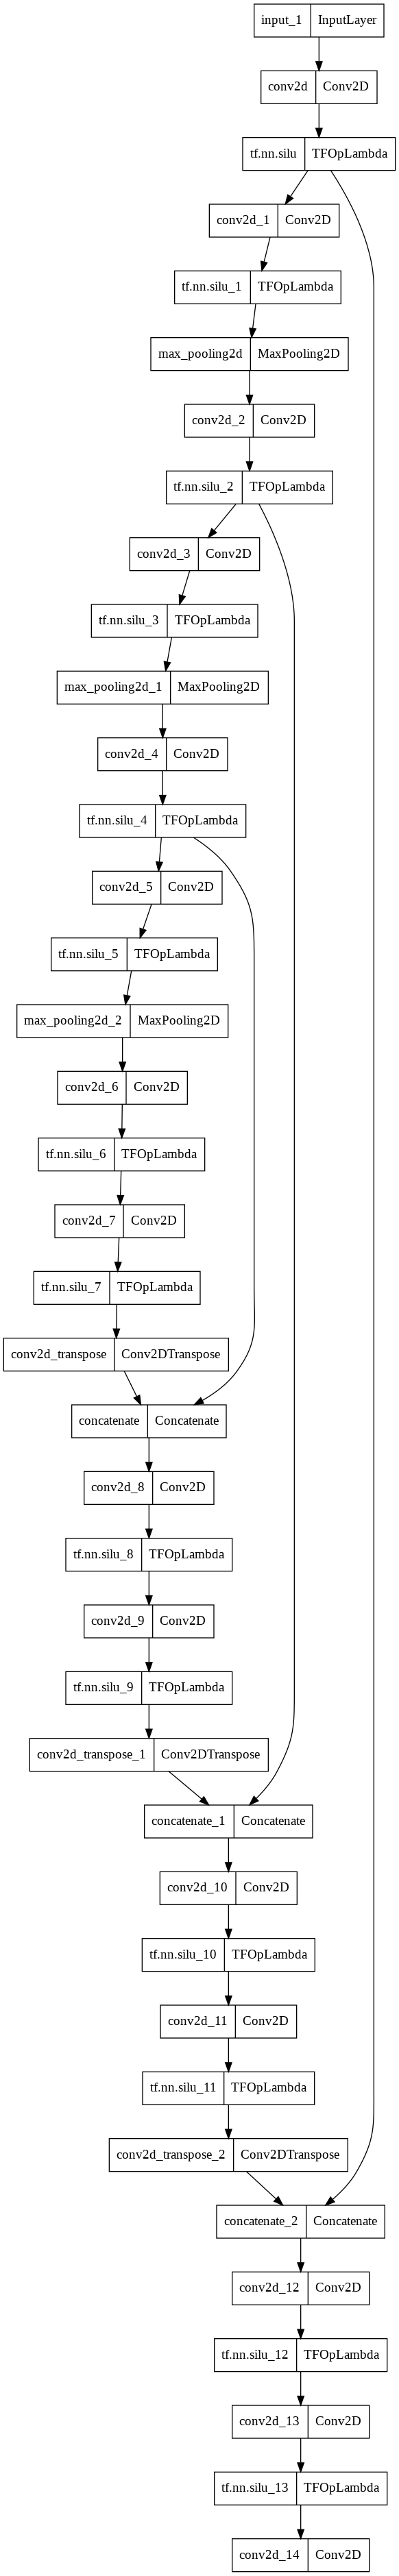

In [ ]:
tf.keras.utils.plot_model(unet_denoiser)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint("./drive/MyDrive/weights/unet_denoiser/weights.{epoch:02d}-{val_loss:.6f}.hdf5", 
                                        monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

hist_unet_denoiser = unet_denoiser.fit(x_train_noise, x_train_original, batch_size=32, epochs=20, validation_split=0.1,
                                      callbacks=[es,mc])

Epoch 1/20
1407/1407 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.0131 - mae: 0.0643
Epoch 1: val_loss improved from inf to 0.00235, saving model to ./drive/MyDrive/weights/unet_denoiser/weights.01-0.002353.hdf5
1407/1407 [==============================] - 31s 13ms/step - loss: 0.0063 - mse: 0.0131 - mae: 0.0643 - val_loss: 0.0024 - val_mse: 0.0047 - val_mae: 0.0498
Epoch 2/20
1404/1407 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0040 - mae: 0.0449
Epoch 2: val_loss improved from 0.00235 to 0.00179, saving model to ./drive/MyDrive/weights/unet_denoiser/weights.02-0.001787.hdf5
1407/1407 [==============================] - 18s 13ms/step - loss: 0.0020 - mse: 0.0040 - mae: 0.0449 - val_loss: 0.0018 - val_mse: 0.0036 - val_mae: 0.0429
Epoch 3/20
1406/1407 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0032 - mae: 0.0403
Epoch 3: val_loss improved from 0.00179 to 0.00146, saving model to ./drive/MyDrive/weights/unet_denoiser/w

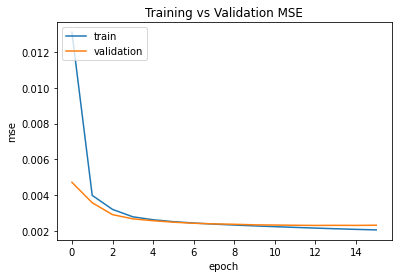

In [ ]:
plt.plot(hist_unet_denoiser.history['mse'])
plt.plot(hist_unet_denoiser.history['val_mse'])
plt.title('Training vs Validation MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
unet_denoiser_test_predictions = unet_denoiser.predict(x_test_noise)
unet_denoiser_test_predictions = tf.clip_by_value(unet_denoiser_test_predictions, 0.0, 1.0)

unet_denoiser_test_mse = tf.keras.losses.MeanSquaredError()(x_test_original, unet_denoiser_test_predictions).numpy()
unet_denoiser_ssim = tf.math.reduce_mean(tf.image.ssim(x_test_original.astype("float32"), unet_denoiser_test_predictions, max_val=1.0)).numpy()
unet_denoiser_psnr = tf.math.reduce_mean(tf.image.psnr(x_test_original.astype("float32"), unet_denoiser_test_predictions, max_val=1.0)).numpy()

print("U-Net Denoiser MSE on test set: %.5f" % unet_denoiser_test_mse)
print("U-Net Denoiser SSIM on test set: %.5f" % unet_denoiser_ssim)
print("U-Net Denoiser PSNR on test set: %.5f" % unet_denoiser_psnr)

U-Net Denoiser MSE on test set: 0.00233
U-Net Denoiser SSIM on test set: 0.87052
U-Net Denoiser PSNR on test set: 26.88483


U-Net obtains good results with respect to the baseline.

# REDNet30 Model

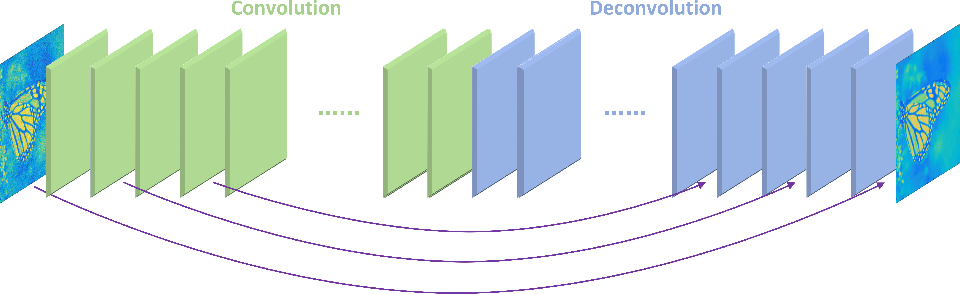

REDNet30 was described in the paper "Image Restoration Using Very Deep Convolutional Encoder-Decoder Networks with Symmetric Skip Connections" (https://arxiv.org/pdf/1603.09056.pdf), and has proven to be successfull in denoising tasks.

It has a very simple and deep architecture, which consists in a chain of convolutional and de-convolutional layers, with the addition of residual connections, which help in backpropagating the gradient to bottom layers and passing image details to higher ones, making the training process more effective.

Convolutions are applied with a kernel size of 3x3, and the number of filters is 64 in all layers of the network except the last one, which has the same number of filters as the channels of the image.

I also used the swish activation function in all the layers except for the last one in which I used the relu for the same reasons of U-Net.

I decided to interleave encoding and decoding layers with BatchNormalization ones, applied before the activation function, as it helps in training such a deep network (it has been successfully used for example in training ResNet https://arxiv.org/abs/1512.03385). This choice has proven to be successful in increasing model's performances in my experiments with REDNet30.


In [ ]:
def REDNet30Encoder(input_layer: keras.layers.Layer, num_layers: int = 15, num_filters: int = 64, kernel_size: int = 3,
                    strides: int = 1, padding: str = "same", activation: typing.Callable = keras.activations.swish,
                    apply_batch_norm: bool = True, apply_batch_norm_before_activation: bool = False) \
        -> typing.List[keras.layers.Layer]:
    layers = []
    layer = input_layer
    for layer_num in range(num_layers):
        layer = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=strides, padding=padding,
                       name='REDNet30Encoder_Convolution_{:d}'.format(layer_num))(layer)
        if not apply_batch_norm:
            layer = activation(layer)
        else:
            if apply_batch_norm_before_activation:
                layer = BatchNormalization(name='REDNet30Encoder_BatchNormalization_{:d}'.format(layer_num))(layer)
                layer = activation(layer)
            else:
                layer = activation(layer)
                layer = BatchNormalization(name='REDNet30Encoder_BatchNormalization_{:d}'.format(layer_num))(layer)

        layers.append(layer)

    return layers


def REDNet30Decoder(residual_layers: typing.List[keras.layers.Layer], num_layers: int = 15, num_filters: int = 64,
                    kernel_size: int = 3, strides: int = 1, padding: str = "same",
                    activation: typing.Callable = keras.activations.swish, apply_batch_norm: bool = True,
                    apply_batch_norm_before_activation: bool = False) -> typing.List[keras.layers.Layer]:
    layers = []
    residual_layers.reverse()
    layer = residual_layers[0]

    for layer_num in range(num_layers):
        layer = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=strides, padding=padding,
                                name='REDNet30Decoder_TransposedConvolution_{:d}'.format(layer_num))(layer)

        if layer_num % 2 == 0:
            layer = keras.layers.Add(name='REDNet30Decoder_SkipConnection_{:d}'.format(layer_num))(
                [layer, residual_layers[layer_num]]
            )

        if not apply_batch_norm:
            layer = activation(layer)
        else:
            if apply_batch_norm_before_activation:
                layer = BatchNormalization(name='REDNet30Decoder_BatchNormalization_{:d}'.format(layer_num))(layer)
                layer = activation(layer)
            else:
                layer = activation(layer)
                layer = BatchNormalization(name='REDNet30Decoder_BatchNormalization_{:d}'.format(layer_num))(layer)

        layers.append(layer)

    return layers


def REDNet30(input_shape: typing.Tuple[int, int, int], num_layers: int = 15, num_filters: int = 64,
             kernel_size: int = 3, strides: int = 1, padding: str = "same",
             activation: typing.Callable = keras.activations.swish,
             apply_batch_norm: bool = True, apply_batch_norm_before_activation: bool = False) -> keras.Model:
    inputs = Input(input_shape)
    encoder = REDNet30Encoder(inputs, num_layers, num_filters, kernel_size, strides, padding, activation,
                              apply_batch_norm, apply_batch_norm_before_activation)

    decoder = REDNet30Decoder(encoder, num_layers, num_filters, kernel_size, strides, padding, activation,
                              apply_batch_norm, apply_batch_norm_before_activation)

    outputs = Conv2DTranspose(filters=input_shape[-1], kernel_size=1, strides=1, padding='same',
                             name='REDNet30Output_TransposedConvolution')(decoder[-1])
    outputs = keras.layers.Add(name='REDNet30Output_SkipConnection')([outputs, inputs])
    outputs = keras.activations.relu(outputs)

    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
rednet30 = REDNet30(input_shape=(32,32,3), apply_batch_norm=True, apply_batch_norm_before_activation=True)

decay_steps = 35000
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(5e-4, decay_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decayed_fn)

rednet30.compile(optimizer=optimizer, loss=tf.keras.losses.log_cosh, metrics=['mse', 'mae'])

print(rednet30.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 REDNet30Encoder_Convolution_0   (None, 32, 32, 64)  1792        ['input_2[0][0]']                
 (Conv2D)                                                                                         
                                                                                                  
 REDNet30Encoder_BatchNormaliza  (None, 32, 32, 64)  256         ['REDNet30Encoder_Convolution_0[0
 tion_0 (BatchNormalization)                                     ][0]']                           
                                                                                            

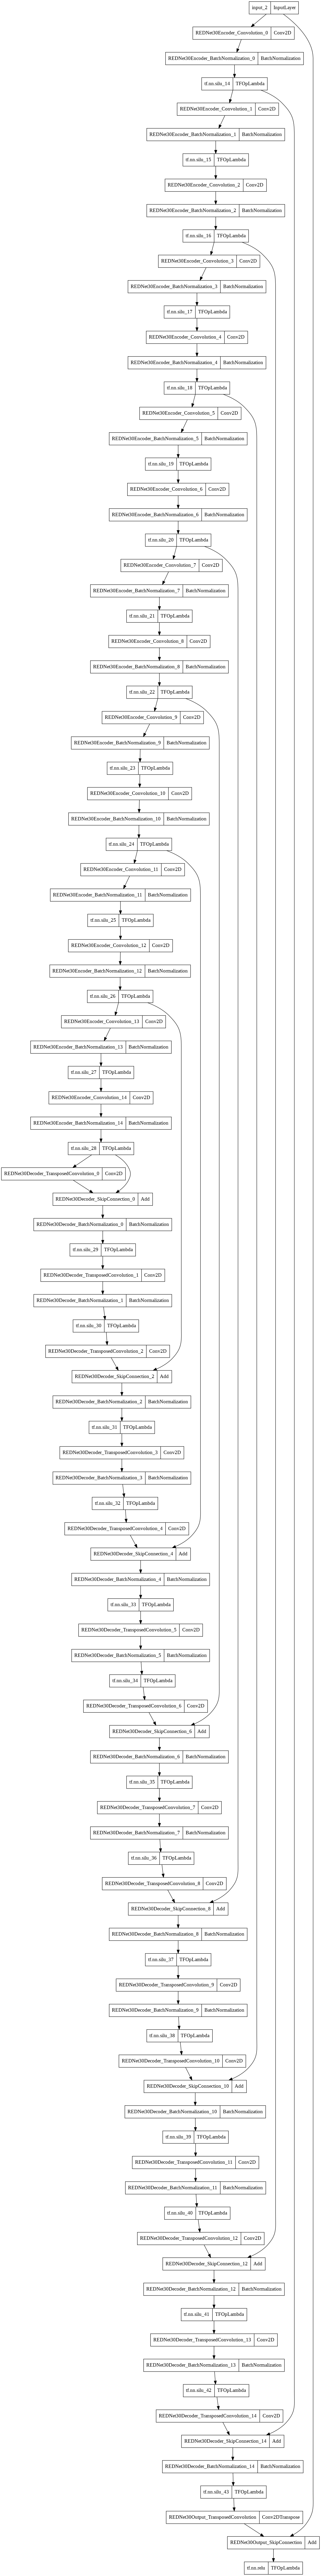

In [ ]:
tf.keras.utils.plot_model(rednet30)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint("./drive/MyDrive/weights/rednet30/weights.{epoch:02d}-{val_loss:.6f}.hdf5", 
                                        monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

hist_rednet30 = rednet30.fit(x_train_noise, x_train_original, batch_size=32, epochs=20, validation_split=0.1,
                             callbacks=[es,mc])

Epoch 1/20
1407/1407 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0053 - mae: 0.0484
Epoch 1: val_loss improved from inf to 0.00241, saving model to ./drive/MyDrive/weights/rednet30/weights.01-0.002408.hdf5
1407/1407 [==============================] - 98s 57ms/step - loss: 0.0026 - mse: 0.0053 - mae: 0.0484 - val_loss: 0.0024 - val_mse: 0.0059 - val_mae: 0.0442
Epoch 2/20
1406/1407 [============================>.] - ETA: 0s - loss: 0.0015 - mse: 0.0030 - mae: 0.0385
Epoch 2: val_loss did not improve from 0.00241
1407/1407 [==============================] - 78s 55ms/step - loss: 0.0015 - mse: 0.0030 - mae: 0.0385 - val_loss: 0.0035 - val_mse: 0.0072 - val_mae: 0.0483
Epoch 3/20
1406/1407 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0028 - mae: 0.0369
Epoch 3: val_loss improved from 0.00241 to 0.00141, saving model to ./drive/MyDrive/weights/rednet30/weights.03-0.001413.hdf5
1407/1407 [==============================] - 78s 56ms/step - loss: 0.0

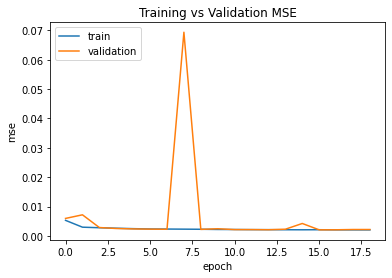

In [ ]:
plt.plot(hist_rednet30.history['mse'])
plt.plot(hist_rednet30.history['val_mse'])
plt.title('Training vs Validation MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

At epoch 8 for some reason the mean squared error on the validation set was pretty high, but after it stabilized. This is not necessarily a sign of overfitting, as it is evident by the results obtained on the test set.

In [ ]:
rednet30_test_predictions = rednet30.predict(x_test_noise)
rednet30_test_predictions = tf.clip_by_value(rednet30_test_predictions, 0.0, 1.0)

rednet30_test_mse = tf.keras.losses.MeanSquaredError()(x_test_original, rednet30_test_predictions).numpy()
rednet30_ssim = tf.math.reduce_mean(tf.image.ssim(x_test_original.astype("float32"), rednet30_test_predictions, max_val=1.0)).numpy()
rednet30_psnr = tf.math.reduce_mean(tf.image.psnr(x_test_original.astype("float32"), rednet30_test_predictions, max_val=1.0)).numpy()

print("REDNet30 MSE on test set: %.5f" % rednet30_test_mse)
print("REDNet30 SSIM on test set: %.5f" % rednet30_ssim)
print("REDNet30 PSNR on test set: %.5f" % rednet30_psnr)

REDNet30 MSE on test set: 0.00205
REDNet30 SSIM on test set: 0.88335
REDNet30 PSNR on test set: 27.41129


REDNet30 shows remarkable improvements with respect to U-Net, achieving a better result both in terms of mse and ssim.

# Restormer
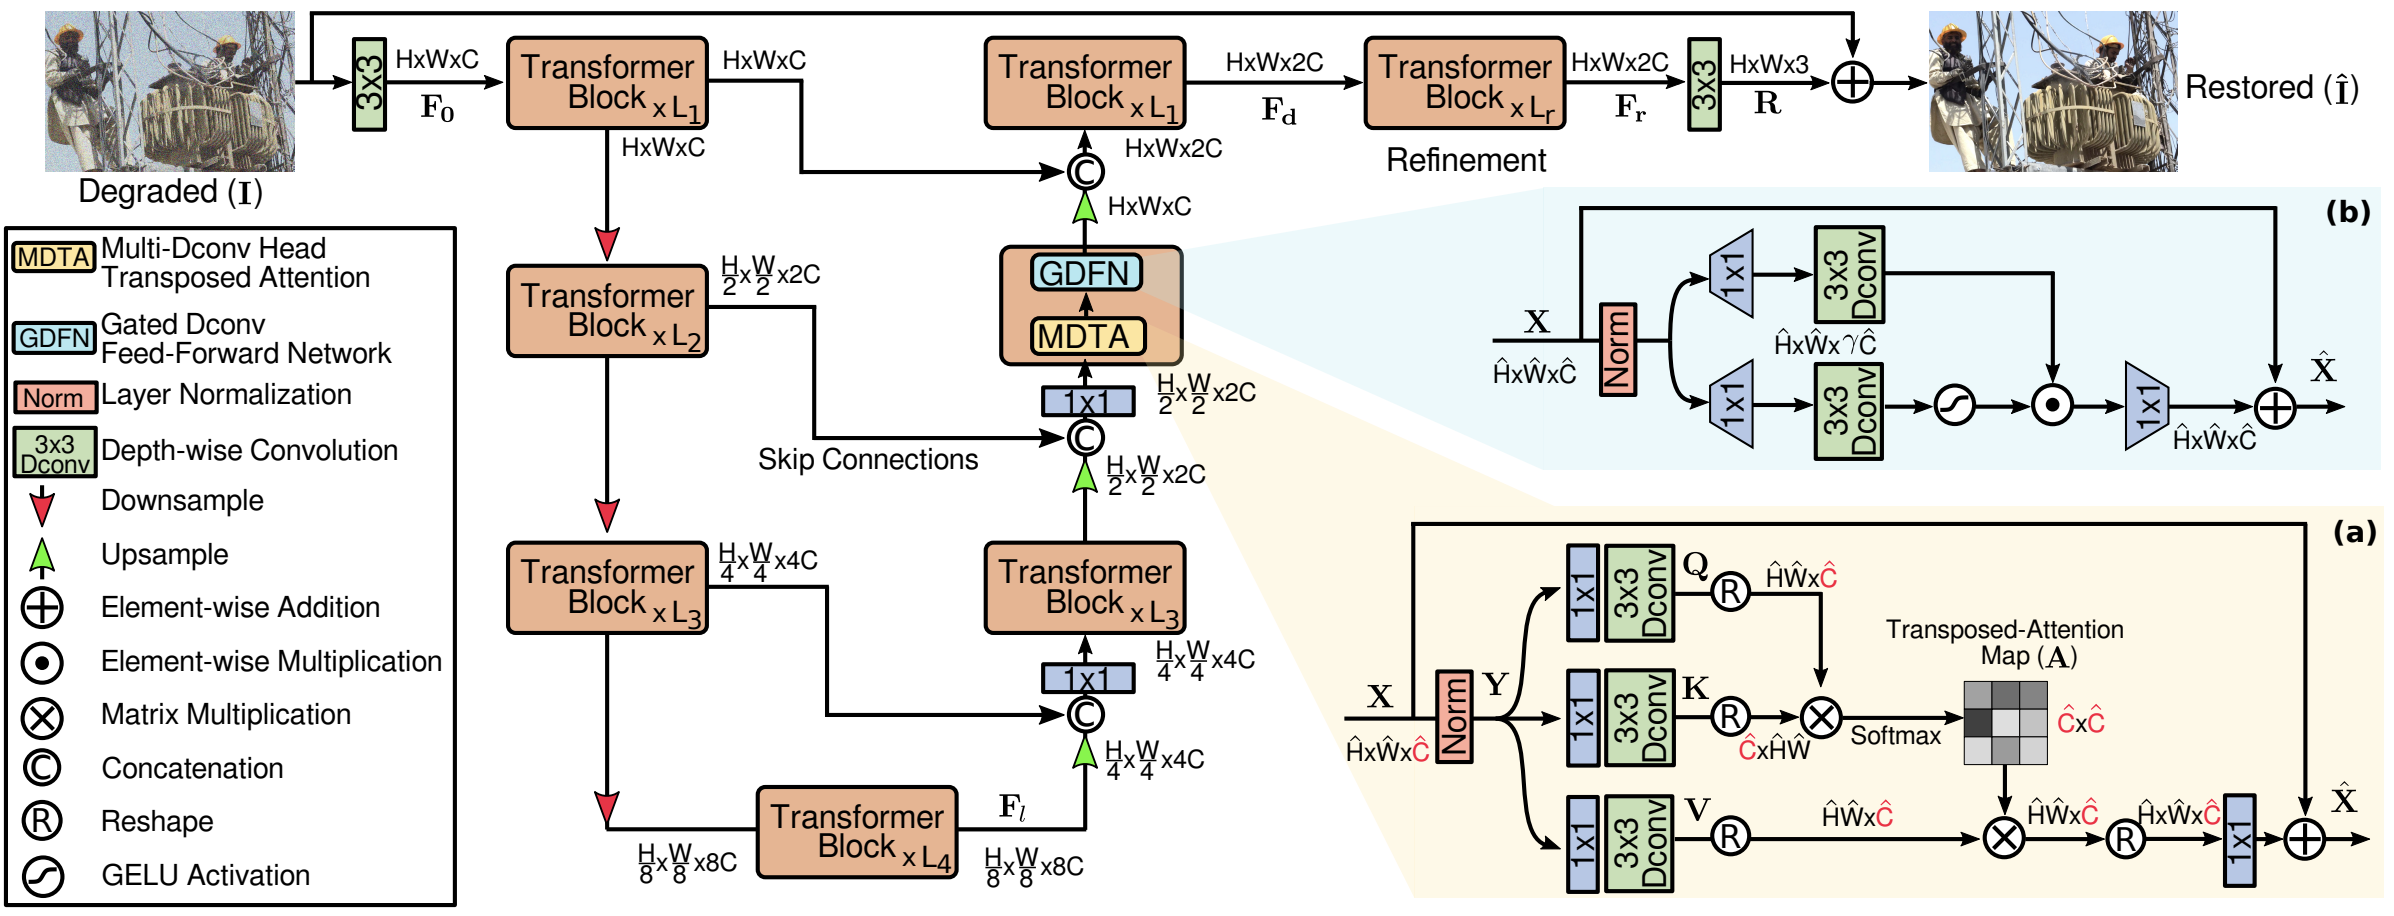

Restormer ("Restormer: Efficient Transformer for High-Resolution Image Restoration" - https://arxiv.org/pdf/2111.09881.pdf) is a recently introduced Transformer model (the paper was published in March 2022), which is specifically designed to address the limitation of traditional transformer models, whose self attention operation's complexity grows quadratically with the spatial resolution of the input, and make it applicable to large images. It reportedly achieves state-of-the-art results on several image restoration tasks, as motion deblurring, defocus deblurring, and image denoising.

To achieve this outcome, the authors introduced a multi-Dconv head transposed attention block which has linear complexity. This is possible thanks to the computation of cross-covariance across channels rather than spatially.

In addition to this, before the computation of self attention, the input is passed through two depth-wise convolutions to emphasize on the local context.

They also made use of a gating mechanism inside one of the building block of the architecture: the gated-dconv feed-forward network. The feed-forward network, which applies an element-wise non-linear transformation to the output of self attention, is a key component of transformer's architectures. 

Specifically, the GDFN block, given an input tensor $X \in ℜ^{\hat{H} × \hat{W} × \hat{C}}$, it outputs:

$\hat{X} = W_{p}^{0} * ϕ(W_{d}^{1}W_{p}^{1}(LN(X)))  ⊙  W_{d}^{2}W_{p}^{2}(LN(X)) + X$,

where $LN(X)$ indicates the layer-normalized input, and $⊙$ indicates the element-wise product operation.
The non linear transformation $ϕ$ used in the paper is the GELU function. In this case, since the Gelu function has been extensively used in Transformers, I decided to stick to the paper, but Swish could also have been used in place of it.

The purpose of the gating mechanism is to control the flow of information, giving the model higher flexibility.

Restormer makes also use of residual connections in a similar manner to U-Net, connecting the output of encoders' blocks with the input of decoders' blocks. (The two tensors are concatenated across the channel dimension and a reduction operation, which is a 1x1 convolution, is used to brings the input back to the correct dimension).

## Restormer Pipeline in Detail

Since input undergo through several dimensionality transformation inside the network, here I give an overview of the pipeline it follows.
For further clarifications I also commented the code to help in the reading.

Starting from the noisy image which has dimension $H × W × 3$, the first operation which is performed is a 3x3 dimension-preserving convolution (padding strategy "same"), to obtain low-level feature embeddings of dimension $H \times W \times C$ where $C$ is the model dimension, which is clearly an hyperparameter to be tuned. 

Then, the input is passed through a symmetric encoder-decoder, undergoing progressive downsampling operations inside the encoder (as in U-Net at each downsampling stage the number of channels is doubled and the spatial dimensions halved), and progressive upsampling operations inside the decoder (again, at each step the spatial dimensions are doubled and the number of channels halved).
As already mentioned, these two components (encoders and decoders) are connected through skip connection. This connection consists in a concatenation operation followed by a 1x1 convolution to reduce the channels.
For downsampling and upsampling operations pixel unshuffling and shuffling is applied (First introduced in https://arxiv.org/abs/1609.05158v2).

The number of transformer blocks constituting each level of the encoder/decoder is progressively increased from the top to bottom levels. As for the model dimension, the number of blocks is also a hyperparameter of the model to be tuned.

Since the architecture has 4 levels in total, the input's dimensionality undergoes the following transformations: $H \times W \times C$ -> $\frac{H}{2} \times \frac{W}{2} \times 2C$ -> $\frac{H}{4} \times \frac{W}{4} \times 4C$ -> $\frac{H}{8} \times \frac{W}{8} \times 8C$ -> $\frac{H}{4} \times \frac{W}{4} \times 4C$ -> $\frac{H}{2} \times \frac{W}{2} \times 2C$ -> $H \times W \times C$.
Since no reduction operation is performed after the concatenation of the first encoder output and the last decoder output, the input will have dimension $H \times W \times 2C$ before going inside the refinement blocks of the network.

Refinement blocks are just subsequent transformer blocks (the number of these blocks is another parameter to be tuned), with dimension $2C$, which do further enrich the input representation.

Lastly through a 3x3 convolution with unitarian stride, a residual image of dimension $H \times W \times 3$ is generated. This image is added to the input ones to obtain the restored image.

Since the residual image could have negative-valued pixels, I set all negative values in the restored image to 0. This operation is performed before testing, in order to correctly compute mean squared error (contrary it could be over-estimated), and have meaningful predictions.

## Hyperparameters' Choice

Since Restormer is a large model, and training takes a long time, I did not have the opportunity to perform automated search in the hyperparameters' space. For this reason, my choices are backed mostly by intuition, and by works done in the literature.
I chose to set the dimensionality of the model (I am here referring to the number of features produced by the first convolution right after the input layer) to 24, because this way, the last encoder will produce an output of dimension $4 \times 4 \times 192$, which has the same flattened dimensionality of the input ($32 \times 32 \times 3$). By using a smaller number of features, the model would learn a compressed embedding of the input which in this particular case, given the strong degradation of images could not be ideal. By using a greater number of features instead, the model would not fit into the 10M parameters requirement.

For the number of blocks, the number of heads, the expansion factor, and the number of refinements, I stuck to the paper.


In [ ]:

# Multi-Dconv Head Transposed Attention
class MDTA(keras.layers.Layer):
    def __init__(self, channels: int, num_heads: int):
        super(MDTA, self).__init__()
        self.num_heads = num_heads
        # Temperature is a learnable scaling parameter to scale down the magnitude of the matrix multiplication of key and query, 
        # avoiding the vanishing gradient phenomenon
        self.temperature = tf.ones((1, num_heads, 1, 1))

        # This first 1x1 convolution is applied to aggregate pixel-wise cross channel context
        self.qkv = keras.layers.Conv2D(filters=channels * 3, kernel_size=1, strides=1, use_bias=False,
                                       data_format='channels_first')
        # This second 3x3 convolution is applied to encode channel-wise spatial context
        self.qkv_conv = keras.layers.Conv2D(filters=channels * 3, kernel_size=3, strides=1, padding='same',
                                            groups=channels * 3, use_bias=False, data_format='channels_first')
        self.project_out = keras.layers.Conv2D(filters=channels, kernel_size=1, strides=1, use_bias=False,
                                               data_format='channels_first')

    def call(self, inputs: tf.Tensor, *args, **kwargs):
        batch_size, channels, height, width = inputs.shape

        query, key, value = tf.split(self.qkv_conv(self.qkv(inputs)), num_or_size_splits=3, axis=1)

        # Through this rescaling operations the result of the dot-product between the query and the key
        # is a transposed attention map of size CxC
        query = einops.rearrange(query, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        key = einops.rearrange(key, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        value = einops.rearrange(value, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        query, key = tf.linalg.normalize(query, axis=-1)[0], tf.linalg.normalize(key, axis=-1)[0]

        # Scaled Dot-Product Attention
        attn = tf.nn.softmax(
            tf.matmul(query, tf.transpose(key, perm=[0, 1, 3, 2])) * self.temperature, axis=-1
        )

        out = tf.matmul(attn, value)
        out = einops.rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=height, w=width)

        # Through projection we go back to CxHxW
        out = self.project_out(out)

        return out

    def get_config(self):
        return {"units": self.units}


# Gated-Dconv Feed-Forward Network
class GDFN(keras.layers.Layer):
    def __init__(self, channels: int, expansion_factor: float):
        super(GDFN, self).__init__()

        hidden_channels = int(channels * expansion_factor)

        # This 1x1 convolutional layer is used to expand the feature channels by the expansion factor
        # The number of filters is hidden_channels multiplied by 2 because the projection is further split into two 
        # chunks across the channels dimension to apply the gating mechanism
        self.project_in = keras.layers.Conv2D(filters=hidden_channels * 2, kernel_size=1, strides=1, use_bias=False,
                                              data_format='channels_first')
        
        # This additional 3x3 convolutional layer has the same purpose of the one in the multi-dconv head transposed attention, 
        # which is to encode information from spatially neighboring pixel positions
        self.conv = keras.layers.Conv2D(filters=hidden_channels * 2, kernel_size=3, strides=1, padding='same',
                                        groups=hidden_channels * 2, use_bias=False, data_format='channels_first')
        
        # This 1x1 convolution reduces channels back to the original input dimension
        self.project_out = keras.layers.Conv2D(filters=channels, kernel_size=1, use_bias=False,
                                               data_format='channels_first')

    def call(self, inputs: tf.Tensor, *args, **kwargs):
        inputs = self.project_in(inputs)

        chunk1, chunk2 = tf.split(self.conv(inputs), num_or_size_splits=2, axis=1)
        # Here non-linearity is applied. In particular in the original paper they used the GELU activation function,
        # which has a shape similar to that of SWISH function. It could be interesting to replace it with SWISH to check 
        # whether results could improve.
        output = self.project_out(keras.activations.gelu(chunk1) * chunk2)

        return output

    def get_config(self):
        return {"units": self.units}


class TransformerBlock(keras.layers.Layer):
    def __init__(self, channels: int, num_heads: int, expansion_factor: float):
        super(TransformerBlock, self).__init__()

        # Both MDTA and GDFN expects layer normalized tensors.
        self.norm_1 = keras.layers.LayerNormalization(axis=-1)
        self.norm_2 = keras.layers.LayerNormalization(axis=-1)
        self.attn = MDTA(channels, num_heads)
        self.ffn = GDFN(channels, expansion_factor)

    def call(self, inputs, *args, **kwargs):
        batch_size, channels, height, width = inputs.shape

        rearranged_input_for_layer_norm = einops.rearrange(inputs, 'b c h w -> b (h w) c')
        normed_inputs_1 = self.norm_1(rearranged_input_for_layer_norm)
        normed_inputs_1 = einops.rearrange(normed_inputs_1, 'b (h w) c -> b c h w', h=height, w=width)

        normed_inputs_2 = self.norm_2(rearranged_input_for_layer_norm)
        normed_inputs_2 = einops.rearrange(normed_inputs_2, 'b (h w) c -> b c h w', h=height, w=width)

        inputs = inputs + self.attn(normed_inputs_1)
        inputs = inputs + self.ffn(normed_inputs_2)

        return inputs

    def get_config(self):
        return {"units": self.units}

# Pixel Shuffle implements efficient sub-pixel convolutions with a stride of 1/r (https://arxiv.org/abs/1609.05158v2)
# From (C*(r^2))*H*W to C*(H×r)*(W×r)
class PixelShuffle(keras.layers.Layer):
    # Adaptation of PyTorch PixelShuffle from there
    # https://github.com/pytorch/pytorch/blob/3a66a1cb99d7e1c1fe7abf8f390e177b9183a436/aten/src/ATen/native/PixelShuffle.cpp#L13-L58

    def __init__(self, upscale_factor: int):
        assert upscale_factor > 0, "PixelShuffle expects a positive upscale_factor"

        super(PixelShuffle, self).__init__()

        self.upscale_factor = upscale_factor
        self.upscale_factor_squared = upscale_factor ** 2

    def call(self, inputs: tf.Tensor, *args, **kwargs):
        batch_size = tf.shape(inputs)[0]
        channels = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        width = tf.shape(inputs)[3]

        output_channels = channels // self.upscale_factor_squared
        ouptut_height = height * self.upscale_factor
        output_width = width * self.upscale_factor

        new_shape = [batch_size, output_channels, self.upscale_factor, self.upscale_factor, height, width]

        inputs_reshaped = tf.reshape(inputs, new_shape)
        inputs_permuted = tf.transpose(inputs_reshaped, perm=[0, 1, 4, 2, 5, 3])
        output = tf.reshape(inputs_permuted, [batch_size, output_channels, ouptut_height, output_width])

        return output

    def get_config(self):
        return {"units": self.units}


# PixelUnShuffle reverts the pixel shuffling operation
# From C*(H*r)*(W*r) to (C*(r^2))*H*W
class PixelUnShuffle(keras.layers.Layer):
    # Adaptation of PyTorch PixelUnShuffle from there
    # https://github.com/pytorch/pytorch/blob/3a66a1cb99d7e1c1fe7abf8f390e177b9183a436/aten/src/ATen/native/PixelShuffle.cpp#L59-L111

    def __init__(self, downscale_factor: int):
        assert downscale_factor > 0, "PixelUnShuffle expects a positive upscale_factor"

        super(PixelUnShuffle, self).__init__()

        self.downscale_factor = downscale_factor
        self.downscale_factor_squared = downscale_factor ** 2

    def call(self, inputs: tf.Tensor, *args, **kwargs):
        batch_size = tf.shape(inputs)[0]
        channels = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        width = tf.shape(inputs)[3]

        output_channels = channels * self.downscale_factor_squared
        ouptut_height = height // self.downscale_factor
        output_width = width // self.downscale_factor

        new_shape = [batch_size, channels, ouptut_height, self.downscale_factor, output_width, self.downscale_factor]

        inputs_reshaped = tf.reshape(inputs, new_shape)
        inputs_permuted = tf.transpose(inputs_reshaped, perm=[0, 1, 3, 5, 2, 4])
        output = tf.reshape(inputs_permuted, [batch_size, output_channels, ouptut_height, output_width])

        return output

    def get_config(self):
        return {"units": self.units}


# The DownSampling layer is applied after encoding transformers' blocks
# This operation first reduces the number of channels by a factor of two
# (through the 3x3 convolution) and than by pixel unshuffling with a downscale factor of two 
# it halves the spatial dimensions and increases the channels dimension by a factor of four
# The transformation is therefore C * H * W --> (C/2) * H * W --> 2C * H/2 * W/2
class DownSample(keras.layers.Layer):
    def __init__(self, channels: int):
        super(DownSample, self).__init__()

        self.conv = keras.layers.Conv2D(filters=channels // 2, kernel_size=3, padding='same', use_bias=False, strides=1,
                                        data_format='channels_first')
        self.pus = PixelUnShuffle(2)

    def call(self, inputs, *args, **kwargs):
        return self.pus(self.conv(inputs))

# The UpSampling layer is applied after decoding transformer's blocks, and it reverses the
# downsampling operation
class UpSample(keras.layers.Layer):
    def __init__(self, channels: int):
        super(UpSample, self).__init__()

        self.conv = keras.layers.Conv2D(filters=channels * 2, kernel_size=3, padding='same', use_bias=False, strides=1,
                                        data_format='channels_first')
        self.ps = PixelShuffle(2)

    def call(self, inputs, *args, **kwargs):
        return self.ps(self.conv(inputs))


def restormer_model(input_size: typing.Tuple[int, int, int] = (32, 32, 3), num_blocks: typing.List[int] = [4, 6, 6, 8],
                    num_heads: typing.List[int] = [1, 2, 4, 8], model_dim: int = 24, num_refinement: int = 4,
                    expansion_factor: float = 2.66, channels_first: bool = False):
    channels = [model_dim * 2 ** i for i in range(0, 4)]

    original_inputs = keras.layers.Input(input_size)

    overlap_patch_embed = keras.layers.Conv2D(filters=channels[0], kernel_size=3, padding='same',
                                              strides=1, use_bias=False, data_format='channels_first')

    encoders = [
        [TransformerBlock(n_channels, n_heads, expansion_factor) for _ in range(n_t_blocks)]
        for n_t_blocks, n_heads, n_channels in zip(num_blocks, num_heads, channels)
    ]

    downsamples = [DownSample(n_channels) for n_channels in channels[:-1]]

    upsamples = [UpSample(n_channels) for n_channels in list(reversed(channels))[:-1]]

    reductions = [
        keras.layers.Conv2D(filters=channels[i - 1], kernel_size=1, strides=1, use_bias=False,
                            data_format='channels_first')
        for i in reversed(range(2, len(channels)))
    ]

    decoders = [[TransformerBlock(channels[2], num_heads[2], expansion_factor)
                 for _ in range(num_blocks[2])],
                [TransformerBlock(channels[1], num_heads[1], expansion_factor)
                 for _ in range(num_blocks[1])],
                [TransformerBlock(channels[1], num_heads[0], expansion_factor)
                 for _ in range(num_blocks[0])]]

    refinement = [TransformerBlock(channels[1], num_heads[0], expansion_factor)
                  for _ in range(num_refinement)]

    output = keras.layers.Conv2D(filters=3, kernel_size=3, padding='same', strides=1, use_bias=False,
                                 data_format='channels_first')

    if not channels_first:
        inputs = tf.transpose(original_inputs, perm=[0, 3, 1, 2])
    else:
        inputs = original_inputs

    embed_inputs = overlap_patch_embed(inputs)
    out_enc1 = embed_inputs
    for i in range(num_blocks[0]):
        out_enc1 = encoders[0][i](out_enc1)

    out_enc2 = downsamples[0](out_enc1)
    for i in range(num_blocks[1]):
        out_enc2 = encoders[1][i](out_enc2)

    out_enc3 = downsamples[1](out_enc2)
    for i in range(num_blocks[2]):
        out_enc3 = encoders[2][i](out_enc3)

    out_enc4 = downsamples[2](out_enc3)
    for i in range(num_blocks[3]):
        out_enc4 = encoders[3][i](out_enc4)

    out_dec3 = reductions[0](tf.concat([upsamples[0](out_enc4), out_enc3], axis=1))
    for i in range(num_blocks[2]):
        out_dec3 = decoders[0][i](out_dec3)

    out_dec2 = reductions[1](tf.concat([upsamples[1](out_dec3), out_enc2], axis=1))
    for i in range(num_blocks[1]):
        out_dec2 = decoders[1][i](out_dec2)

    out_dec1 = tf.concat([upsamples[2](out_dec2), out_enc1], axis=1)
    for i in range(num_blocks[0]):
        out_dec1 = decoders[2][i](out_dec1)

    fr = out_dec1
    for i in range(num_refinement):
        fr = refinement[i](fr)

    out = output(fr) + inputs

    if not channels_first:
        out = tf.transpose(out, perm=[0, 2, 3, 1])

    return keras.Model(inputs=original_inputs, outputs=out)


In [ ]:
restormer = restormer_model(channels_first=False)

decay_steps = 35000
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(1e-3, decay_steps)
optimizer = tfa.optimizers.AdamW(learning_rate=lr_decayed_fn, weight_decay=1e-4)

restormer.compile(optimizer=optimizer, loss=tf.keras.losses.log_cosh, metrics=['mse', 'mae'])

print(restormer.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 tf.compat.v1.transpose (TFOpLa  (None, 3, 32, 32)   0           ['input_3[0][0]']                
 mbda)                                                                                            
                                                                                                  
 conv2d_15 (Conv2D)             (None, 24, 32, 32)   648         ['tf.compat.v1.transpose[0][0]'] 
                                                                                                  
 transformer_block (Transformer  (None, 24, 32, 32)  8718        ['conv2d_15[0][0]']        

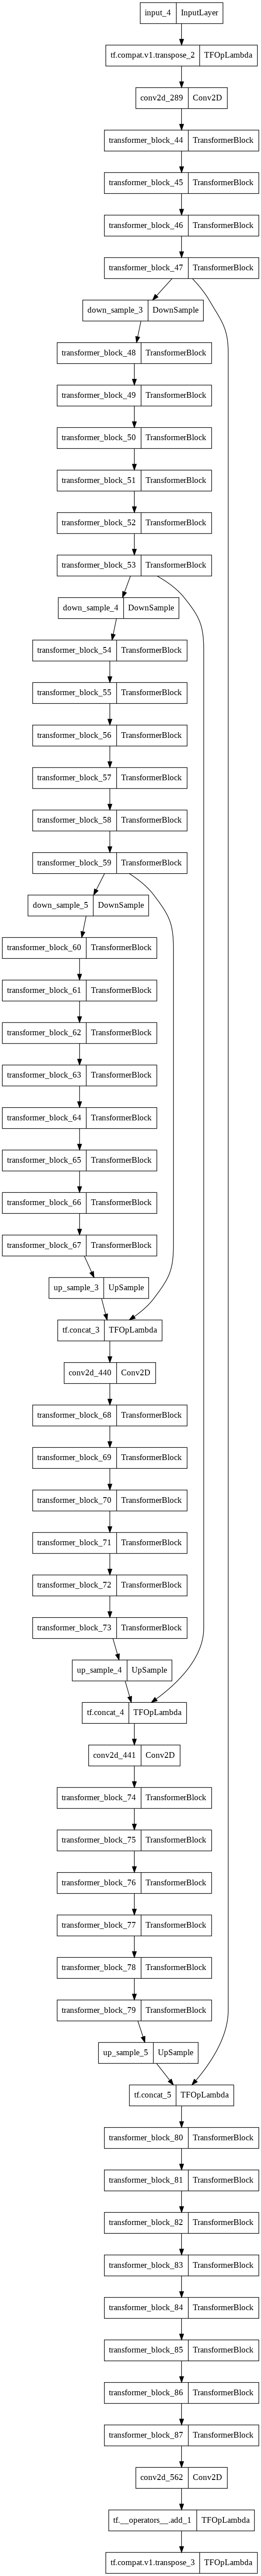

In [ ]:
tf.keras.utils.plot_model(restormer)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint("./drive/MyDrive/weights/restormer/weights.{epoch:02d}-{val_loss:.6f}.hdf5", 
                                        monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

hist_restormer = restormer.fit(x_train_noise, x_train_original, batch_size=32, epochs=20, validation_split=0.1,
                               callbacks=[es,mc])

Epoch 1/20
1407/1407 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0035 - mae: 0.0413
Epoch 1: val_loss improved from inf to 0.00125, saving model to ./drive/MyDrive/weights/restormer/weights.01-0.001254.hdf5
1407/1407 [==============================] - 529s 336ms/step - loss: 0.0018 - mse: 0.0035 - mae: 0.0413 - val_loss: 0.0013 - val_mse: 0.0025 - val_mae: 0.0352
Epoch 2/20
1407/1407 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0024 - mae: 0.0341
Epoch 2: val_loss improved from 0.00125 to 0.00116, saving model to ./drive/MyDrive/weights/restormer/weights.02-0.001155.hdf5
1407/1407 [==============================] - 474s 337ms/step - loss: 0.0012 - mse: 0.0024 - mae: 0.0341 - val_loss: 0.0012 - val_mse: 0.0023 - val_mae: 0.0336
Epoch 3/20
1407/1407 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0022 - mae: 0.0329
Epoch 3: val_loss improved from 0.00116 to 0.00109, saving model to ./drive/MyDrive/weights/restormer/weights.0

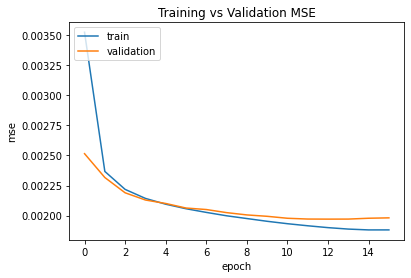

In [ ]:
plt.plot(hist_restormer.history['mse'])
plt.plot(hist_restormer.history['val_mse'])
plt.title('Training vs Validation MSE')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
restormer_test_predictions = restormer.predict(x_test_noise)
restormer_test_predictions = tf.clip_by_value(restormer_test_predictions, 0.0, 1.0)

restormer_test_mse = tf.keras.losses.MeanSquaredError()(x_test_original, restormer_test_predictions).numpy()
restormer_ssim = tf.math.reduce_mean(tf.image.ssim(x_test_original.astype("float32"), restormer_test_predictions, max_val=1.0)).numpy()
restormer_psnr = tf.math.reduce_mean(tf.image.psnr(x_test_original.astype("float32"), restormer_test_predictions, max_val=1.0)).numpy()

print("Restormer MSE on test set: %.5f" % restormer_test_mse)
print("Restormer SSIM on test set: %.5f" % restormer_ssim)
print("Restormer PSNR on test set: %.5f" % restormer_psnr)

Restormer MSE on test set: 0.00197
Restormer SSIM on test set: 0.88728
Restormer PSNR on test set: 27.60303


As expected, Restormer is the top performing model, achieving an improvement of 5.24 in terms of PSNR and of 0.00476 in terms of MSE with respect to the baseline. 

It is not winning over REDNet by a large margin but I suspect that this mainly as to do with the dataset.

# Graphical Inspection of Models and Summary of Results

In [ ]:
def show_images(images, titles=None, grid=False, figsize=(32, 32), title_fontsize=30):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    
    axes = list(axes.flat)

    for i in range(len(images)):
        img    = images[i]
        title  = titles[i]
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize=title_fontsize) 
        axes[i].grid(grid)

    for i in range(len(images), len(axes)):
        axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

In [ ]:
unet_denoiser.load_weights("./drive/MyDrive/weights/unet_denoiser/weights.13-0.001157.hdf5")
rednet30.load_weights("./drive/MyDrive/weights/rednet30/weights.16-0.001024.hdf5")
restormer.load_weights("./drive/MyDrive/weights/restormer/weights.13-0.000983.hdf5")

In [ ]:
unet_denoiser_test_predictions = unet_denoiser.predict(x_test_noise)
unet_denoiser_test_predictions = tf.clip_by_value(unet_denoiser_test_predictions, 0.0, 1.0)

rednet30_test_predictions = rednet30.predict(x_test_noise)
rednet30_test_predictions = tf.clip_by_value(rednet30_test_predictions, 0.0, 1.0)

restormer_test_predictions = restormer.predict(x_test_noise)
restormer_test_predictions = tf.clip_by_value(restormer_test_predictions, 0.0, 1.0)

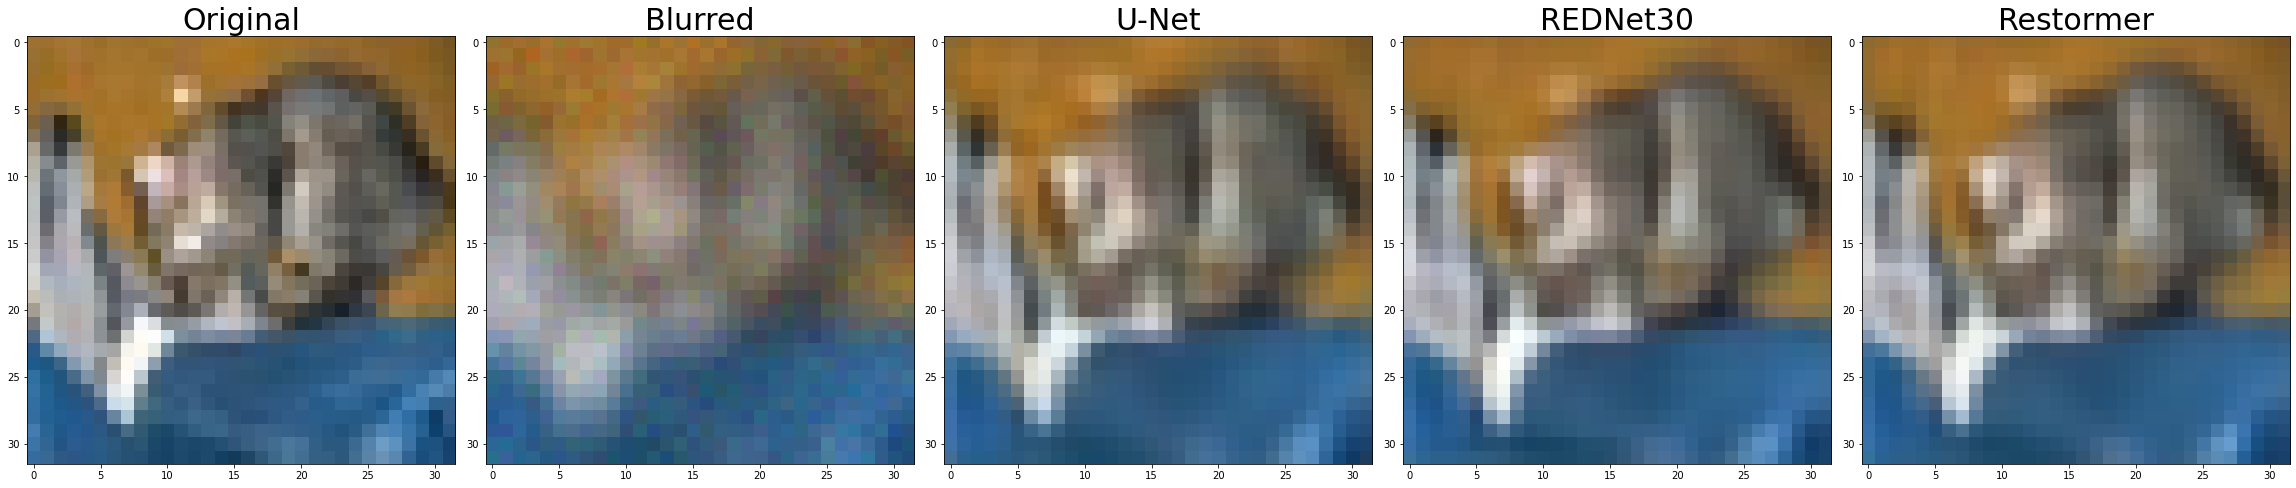

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


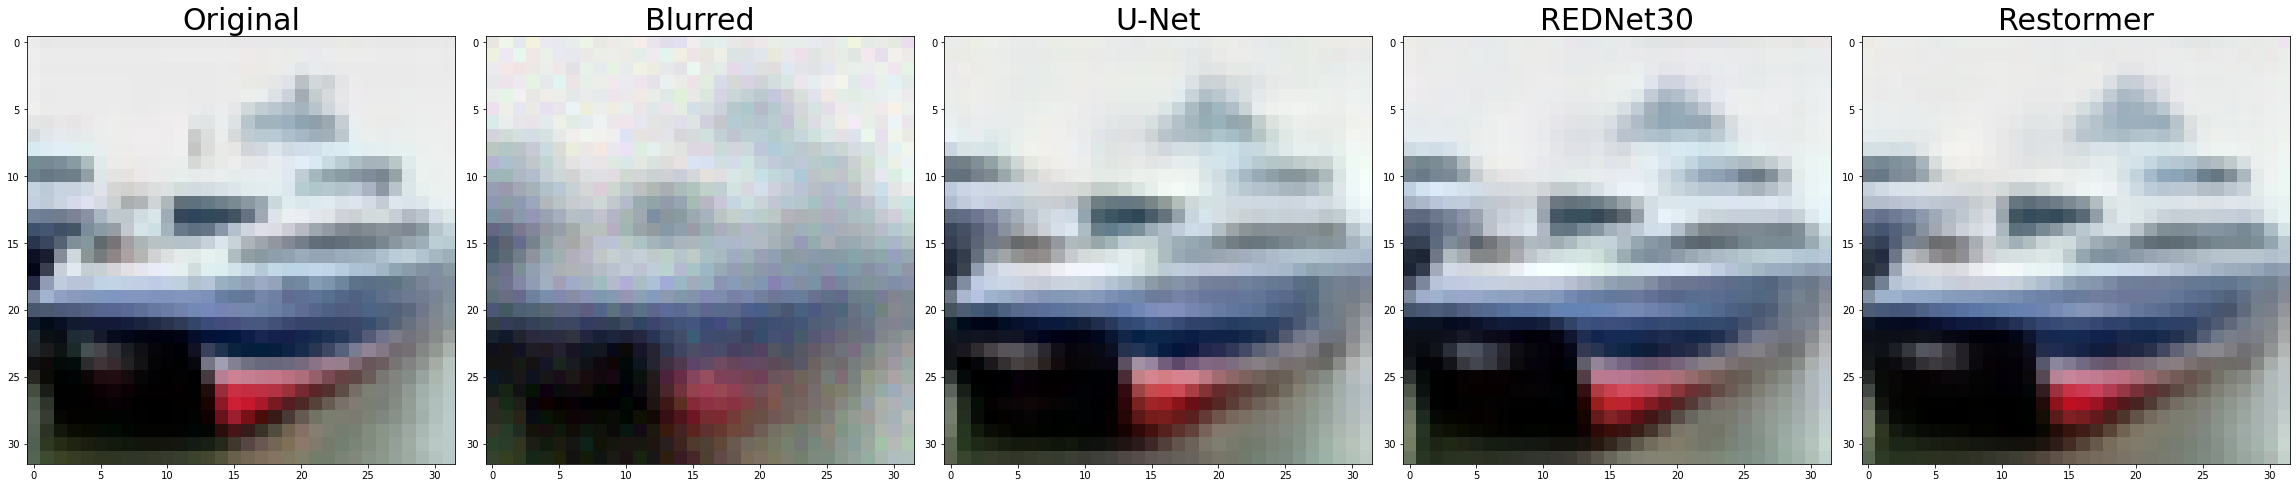

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


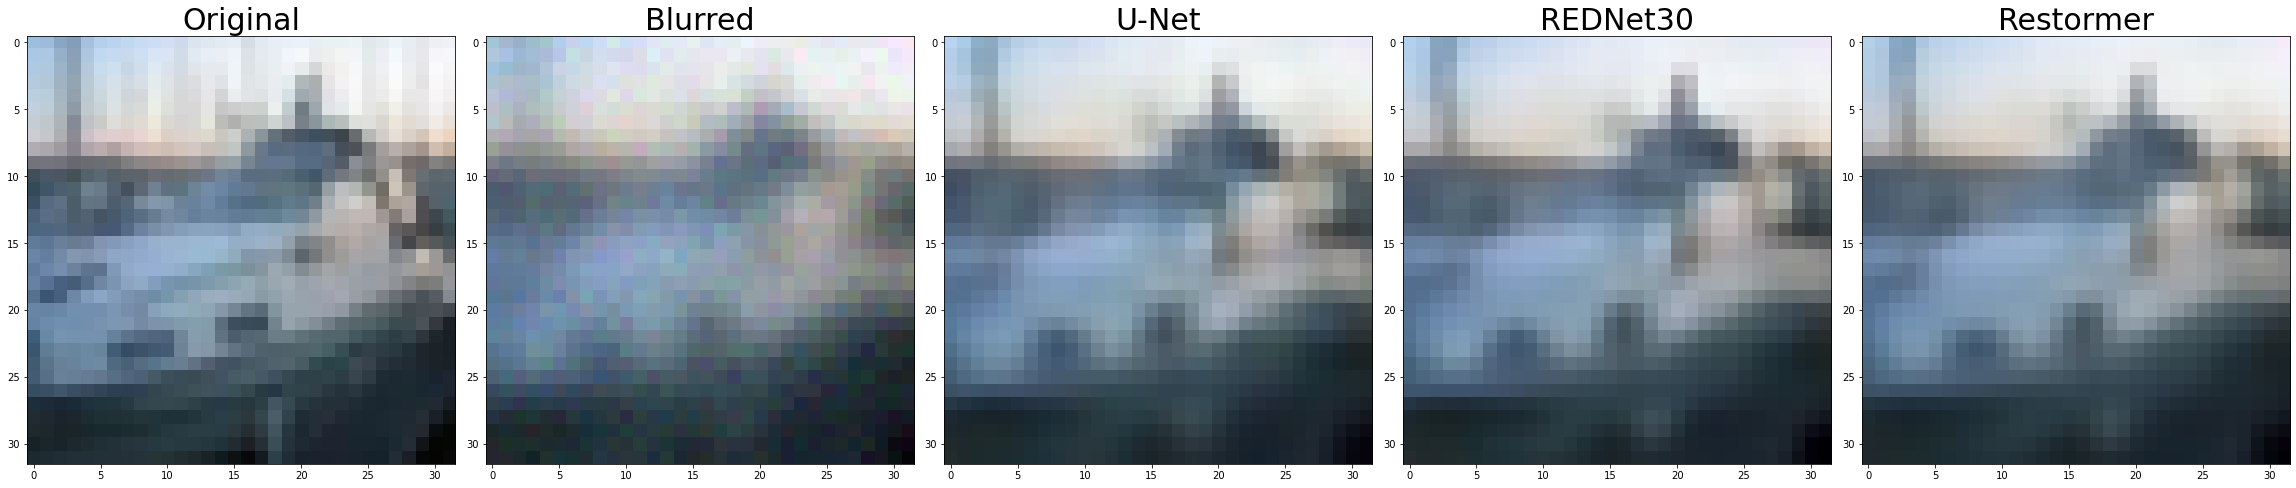

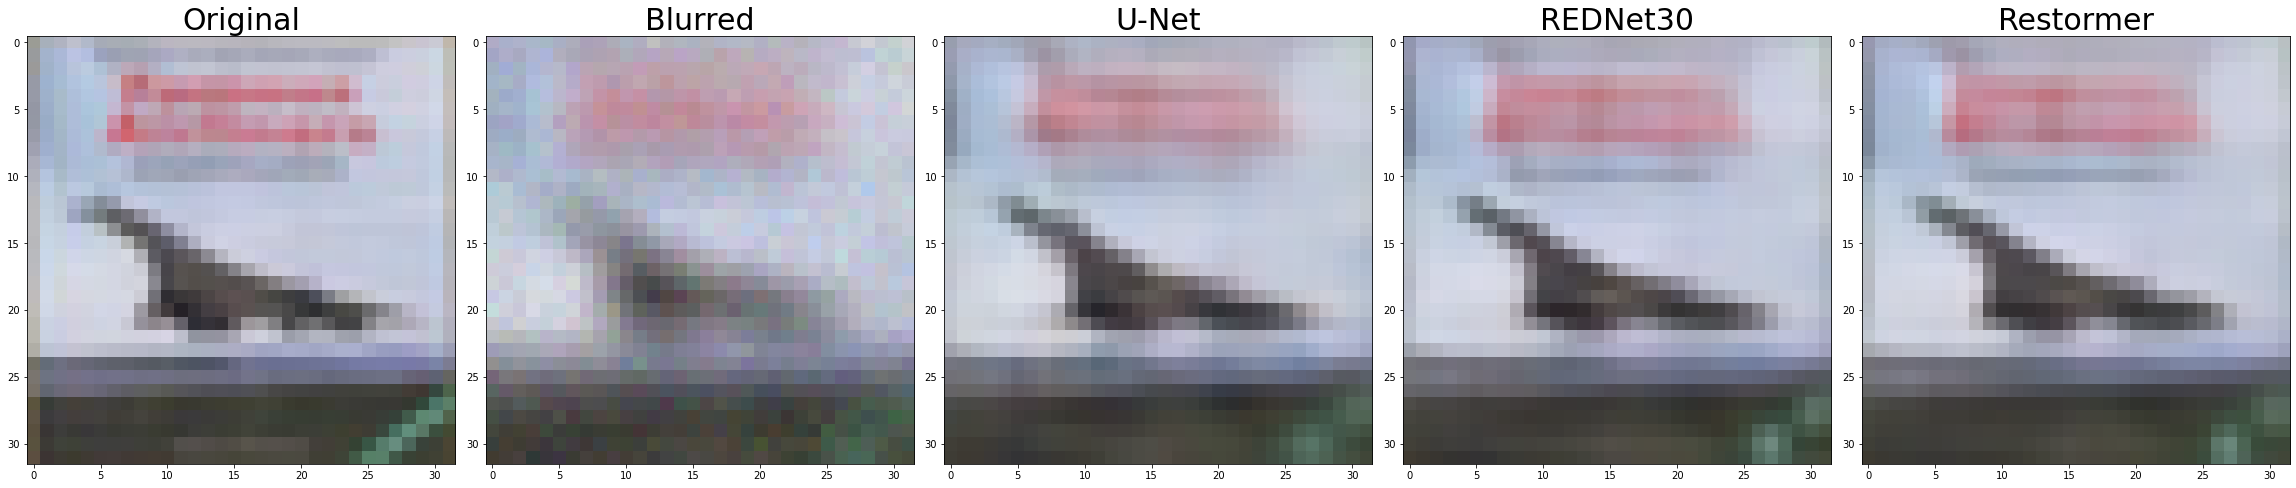

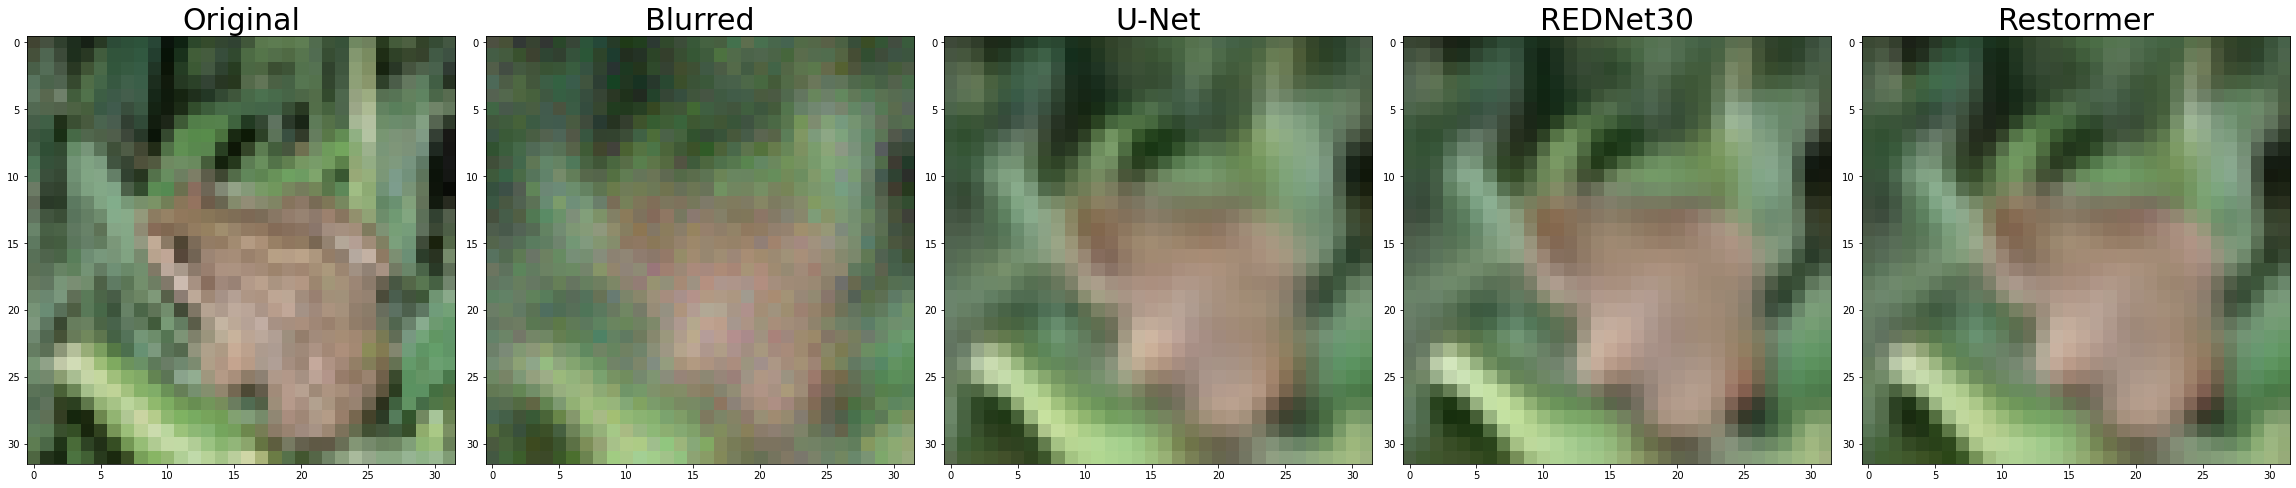

In [ ]:
for index in range(5):
  images = [
            x_test_original[index],
            x_test_noise[index], 
            unet_denoiser_test_predictions[index], 
            rednet30_test_predictions[index], 
            restormer_test_predictions[index]
  ]
  show_images(images, ["Original", "Blurred", "U-Net", "REDNet30", "Restormer"])

It is difficult to grasp differences between the models by graphically inspecting their output, but for sure denoising is working as expected!

### Comparison Table

| Metric      | U-Net  | REDNet30| Restormer |
| :---        | :----: | :----:  |  :----:   |
| MSE         | 0.0233 | 0.00205 | 0.00197   |
| PSNR        | 26.881 | 27.411  | 27.603    |
| SSIM        | 0.8704 | 0.883   | 0.887     |

# Conclusion

### Of the three models that I have implemented the best one, according to both MSE and SSIM, is Restormer.

#### Weights can be found inside the following Google Drive folder: https://drive.google.com/drive/folders/1BqGPE9bXp-rmQNpIWeBqvRK0E1sZwE79?usp=sharing